# Vehicle Model

We consider the double integrator as a model for UAV flight path simulation model as below.

The system dynamics 
\begin{equation}
x_{t+1} = A x_t + B u_t, \quad x_0 = [0 ,0, 0, 0]^\top,
\end{equation}
where
\begin{equation}
A = \begin{bmatrix}
     1 & 0 & 0.1 & 0   \\
     0 & 1 &  0 & 0.1 \\
     0 & 0 &  1 & 0   \\
     0 & 0 &  0 & 1
     \end{bmatrix}
\quad
B = \begin{bmatrix}
     0  & 0  \\
     0  & 0  \\
     0.1 & 0  \\
     0  & 0.1
     \end{bmatrix}
\end{equation} 

Now, we need to feed the control input tensor to the dynamics for the time horizon $N$.

In [1]:
import torch
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

A = torch.FloatTensor([[1, 0, 0.1, 0],[0, 1, 0, 0.1],[0, 0, 1,0],[0,0,0,1]]).to(DEVICE)
B = torch.FloatTensor([[0, 0],[0, 0],[.1, 0],[0,.1]]).to(DEVICE)
x_0 = torch.FloatTensor([0, 0, 0, 0]).to(DEVICE)

In [2]:
N   = 20 # Time horizon
N_u = 2  # dimension of the control input.
N_x = 4  # dimension of the state space.
N_smpl = 1000 # MPPI 

# Functions and other utility for simulation

In [3]:
### Simulate the multiple trajectories ###
def calculate_state_trajectories(A, B, x_0, U_tensor):
    
    '''
    given:
    A : 4 by 4 matrix
    B : 4 by 2 matrix
    x_0 initial state with size (4)
    U_tensor: N_path, M_destination, N_time, N_u, N_smpl
    
    return:
    XX_tensor: N_path, M_destination, N_time, N_u, N_smpl
    '''
    
    ### Get the shape of the input tensor ###
    N_time, N_u, N_smpl = U_tensor.size()
    
    ### Initialize the state value ###
    #print('x_0', x_0.size())
    X_t = x_0.unsqueeze(-1).repeat(1, 1, N_smpl)
    # X_t: 1, N_x, N_smpl
    
    X_t = X_t.to(DEVICE).permute(2,1,0)#.unsqueeze(-1)
    BB = B.unsqueeze(0).repeat(N_smpl, 1, 1).to(DEVICE)
    AA = A.unsqueeze(0).repeat(N_smpl, 1, 1).to(DEVICE)
    
    XX_tensor = []
    for t in range(N_time):
        U_t = U_tensor[t,:,:].permute(1,0).unsqueeze(-1)
        BU = torch.matmul(BB, U_t)
        AX = torch.matmul(AA, X_t)
        X_t = AX + BU
        XX_tensor.append(X_t)
    XX_tensor  = torch.stack(XX_tensor, -1).squeeze()
    return XX_tensor

We consider the primary desination (10, 10).

And the usual quadratic cost are used with
\begin{equation}
L_\text{q}(x, u) = (x - x_\text{tgt})^\top Q (x - x_\text{tgt}) + u^\top R u
\end{equation}

Now, we are considering the obstacle avoidance constraint. A simple inequality with vertices (4, 4) and (6, 8). The obstacle occupy the following intervals.
\begin{equation}
\begin{aligned}
    4 \leq x \leq 6 \\
    4 \leq y \leq 8
\end{aligned}
\end{equation}

We add the penalty cost to the quadratic cost with the penalty weight $W_\text{penalty}$ as
\begin{equation}
L(x, u) = L_\text{q}(x, u) + W_\text{penalty}\mathbb{1}[x \in \text{Obstacle}]
\end{equation}

In [4]:
class CostCalculator:
    def __init__(self, X_goal):
        self.X_goal = X_goal
        
        self.Q_running = torch.FloatTensor([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]]).to(DEVICE)
        self.R_running = torch.FloatTensor([[0, 0],[0, 0]]).to(DEVICE)

        self.Q_terminal = torch.FloatTensor([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]]).to(DEVICE)
        self.R_terminal = torch.FloatTensor([[1, 0],[0, 1]]).to(DEVICE)
        
        self.Box_to_Avoid = {}
        self.Box_to_Avoid.update({'LB_X':4})
        self.Box_to_Avoid.update({'UB_X':6})
        self.Box_to_Avoid.update({'LB_Y':4})
        self.Box_to_Avoid.update({'UB_Y':8})
        self.GAP = 0.2
        self.W_penalty = 10000
        
    def calcualte(self, XX, UU):
        
        N_smpl, N_state, N_time = XX.size()
        
        ### Repeat and reshaping the tensors ###
        XX_goal = self.X_goal.unsqueeze(-1)
        XX_goal = XX_goal.repeat(N_smpl, 1, N_time)
        
        ##################################
        ### Calculate the running cost ###
        ##################################
        
        ### Error Cost: x_T*Q*x ###
        QQ = self.Q_running.unsqueeze(0).unsqueeze(0).repeat(N_smpl, N_time, 1, 1)
        EE = (XX - XX_goal).unsqueeze(-1).permute(0,2,1,3)
        EE_T = EE.permute(0,1,3,2)
        EEQQEE = torch.matmul(EE_T, torch.matmul(QQ, EE))
        ### Control Cost: u_T*R*u ###
        RR = self.R_running.unsqueeze(0).unsqueeze(0).repeat(N_smpl, N_time, 1, 1)
        UU = UU.permute(2, 0, 1).unsqueeze(-1)
        UU_T = UU.permute(0,1,3,2)
        UURRUU = torch.matmul(UU_T, torch.matmul(RR, UU))
        ### Indicator in the obstacle space ###
        XX_x = XX[:, 0, :]
        XX_y = XX[:, 1, :]
        
        LB_X = self.Box_to_Avoid['LB_X']
        UB_X = self.Box_to_Avoid['UB_X']
        LB_Y = self.Box_to_Avoid['LB_Y']
        UB_Y = self.Box_to_Avoid['UB_Y']
        GAP  = self.GAP
        W_penalty = self.W_penalty
        
        If_Within_Obstacle = (XX_x > LB_X-GAP).type(torch.float)*(XX_x < UB_X+GAP).type(torch.float)*(XX_y > LB_Y-GAP).type(torch.float)*(XX_y < UB_Y+GAP).type(torch.float)
        If_Within_Obstacle = If_Within_Obstacle.unsqueeze(-1)
        
        ### Running cost L tensor ###
        LL = EEQQEE.squeeze() + UURRUU.squeeze() + W_penalty * If_Within_Obstacle.squeeze()
        
        ###################################
        ### Calculate the terminal cost ###
        ###################################
        XX_terminal  = XX[:,:,-1].unsqueeze(-1)
        XX_goal = XX_goal[:,:,-1].unsqueeze(-1)
        
        ### Error Cost: x_T*Q*x ###
        QQ = self.Q_terminal.unsqueeze(0).repeat(N_smpl, 1, 1)
        EE = (XX_terminal - XX_goal)
        EE_T = EE.permute(0,2,1)
        EEQQEE = torch.matmul(EE_T, torch.matmul(QQ, EE)).squeeze()
        
        
        UU_terminal = UU[:,-1,:,:].squeeze().unsqueeze(-1)
        RR = self.R_terminal.unsqueeze(0).repeat(N_smpl, 1, 1)
        UU_terminal_T = UU_terminal.permute(0, 2, 1)
        UURRUU = torch.matmul(UU_terminal_T, torch.matmul(RR, UU_terminal)).squeeze()
        
        FF = EEQQEE.squeeze() + UURRUU.squeeze()
        
        cost = torch.mean(LL, 1) + FF
                
        return cost

UU = torch.randn(N, N_u, N_smpl).to(DEVICE)

### Simulate the random trajctories ###
x_0 = torch.zeros(N_x).to(DEVICE)
XX = calculate_state_trajectories(A, B, x_0, UU)

X_goal = torch.FloatTensor([[10, 10, 0, 0]]).to(DEVICE)     
cost_calculator = CostCalculator(X_goal)
cost = cost_calculator.calcualte(XX, UU)

print('cost', cost.size())


cost torch.Size([1000])


Now, we are runing the simulation.

In [5]:
import tqdm

### Simulate the random trajctories ###
x_0 = torch.zeros(N_x).to(DEVICE)
X_goal = torch.FloatTensor([[8, 8, 0, 0]]).to(DEVICE)     
cost_calculator = CostCalculator(X_goal)

LAMBDA = 1.0 # MPPI Param

def run_sim():
    x_t = x_0 # Initizlize the state for SIM
    T_sim = 1000

    x_sim_result = []
    u_sim_result = []

    for t in tqdm.tqdm(range(T_sim)):
        
        ### Sampling and construct the control table ###
        UU = torch.randn(N, N_u, N_smpl).to(DEVICE)
        
        ### Simulate the random trajctories for Optimizaiton (MPPI) ###
        XX = calculate_state_trajectories(A, B, x_t, UU)
        
        ### Calcualte the costs of state trajectories ###
        J = cost_calculator.calcualte(XX, UU)
        
        ### Stochastic optimziaiton (MPPI) ####
        # Now get the weight for MPPI 
        energy = torch.exp(-1/LAMBDA*(J-J.min()))
        weight_mppi = energy / torch.sum(energy)
        
        # Get weighted sum for u_t
        U_first_samples = UU[0,:,:].squeeze()
        u_t  = torch.sum(U_first_samples*weight_mppi,1)
        
        #print('u_t', u_t.size())
        #print('x_t', x_t.size())
        
        ### Use it with the system ###
        x_t = x_t.unsqueeze(-1)
        x_tp1 = torch.matmul(A,x_t) + torch.matmul(B,u_t.unsqueeze(-1))
        x_t = x_tp1.squeeze()
        
        #print('x_tp1', x_tp1.size())

        ### Append data for plotting ###
        x_sim_result.append(x_t)
        u_sim_result.append(u_t)

    x_sim_result = torch.stack(x_sim_result)
    u_sim_result = torch.stack(u_sim_result)
    
    return x_sim_result, u_sim_result

Simulate and Plot the results.

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.79it/s]
No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


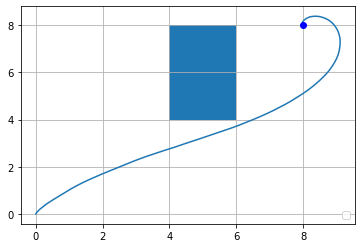

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


fig, ax = plt.subplots()

list_gammas = [0.0, 0.7]

    
x_sim_result, u_sim_result = run_sim()

if DEVICE != "cpu":
    x = x_sim_result[:,0].cpu().numpy()
    y = x_sim_result[:,1].cpu().numpy()
else:
    x = x_sim_result[:,0].numpy()
    y = x_sim_result[:,1].numpy()

ax.plot(x, y) 
    
### Add goal positions ###
if DEVICE != "cpu":
    np_X_goal = X_goal.cpu().numpy()
else:
    np_X_goal = X_goal.numpy()

### Add goal positions ###
ax.plot(np_X_goal[0,0], np_X_goal[0,1], 'bo')

### Add the rect. obs. ###
LB_X = cost_calculator.Box_to_Avoid['LB_X']
UB_X = cost_calculator.Box_to_Avoid['UB_X']
LB_Y = cost_calculator.Box_to_Avoid['LB_Y']
UB_Y = cost_calculator.Box_to_Avoid['UB_Y']

ax.add_patch(Rectangle((LB_X, LB_Y), UB_X - LB_X, UB_Y - LB_Y))
    
ax.grid()
plt.legend(loc='lower right')
fig.savefig('figures/example1.eps', format='eps')
fig.savefig('figures/example1.png')
plt.show()